# Создал этот ноутбук для проверки простеньких сеток на синтетических датасетах / кусках датасетов

здесь можно потестить на синтетике, а потом еще и зафитить для к=1 и потом уже задебагать код

- Пока понял, что лучше не в виде матриц хранить внутри датасета, а сразу выпрямлять и тогда батчи будут иметь size: (batch_size, KxK), тогда понятно, что для K=1 не стоит сквизить

- Походу в функциях обучения есть бага

In [130]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler

import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [131]:
def function(X):
    return 5 * X

In [132]:
class CFG:
    '''

    All hyperparameters are here

    '''

    N = 2     # число атомов
    K = 1     # можно называть это разрешением...чем число больше, тем больше размеры матрицы для атомов, фактически это число элементов в наборах p и r_cut

    L = 2 * N ** (1 / 3) # размер одной клетки при моделировании

    r_cut = np.random.uniform(low=5, high=10, size=K).copy()
    p = np.random.uniform(low=1, high=3, size=K).copy()
    N_neig= N - 1 if N != 2 else 1

    # train_bs = 8
    # val_bs = 16
    batch_size = 64

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    f_threshold = 5    # Если сила по какой-то координате превышает это значение, то строчка исключается, совсем маленьких по модулю сил быть не должно, если что при генерации просто r_cut поменьше надо делать
    coord_threshold = L     # Если вдруг очень большие расстояния, то надо выкидывать
    f_min_threshold = 0.05
    #
    output_size = K     # Размерность аутпута модели

In [133]:
def create_dataloaders(train_dataset, val_dataset, train_bs=64, val_bs=64, fold=None):
    '''

    Returns train_loader, val_loader

    fold: will be used in cross validation, when I will implement it

    '''
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=train_bs, shuffle=True)

    val_loader = DataLoader(dataset=val_dataset, batch_size=val_bs, shuffle=False)

    return train_loader, val_loader

In [134]:
def plot_k_dim_f_norm_from_x_norm(data_sample, figsize=(15, 10), fontsize=18):
    '''

    Функция строит зависимость таргета от X

    data_sample - итерируемый объект из тьюплов вида: (x, f_k_dim, f_3d, pinv_A)

    '''
    plt.figure(figsize=figsize)
    x = torch.stack([elem[0][0].squeeze() for elem in data_sample])

    y = torch.stack([elem[1][0].squeeze() for elem in data_sample])

    plt.scatter(x, y, label='y(x)')
    plt.title('Зависимость $Y_{target}(X)$', fontsize=fontsize)

    None

In [135]:
# class MultiOutputMSELoss(nn.MSELoss):
#     '''

#     Custom loss that calculates average over batch loss for multidim MSE - sum of MSE for components

#     Example:
#     |
#     |    Loss = MultiOutputMSELoss()
#     |
#     |    a = torch.ones((8, 3))      # it is batch of 8 vectors of size 3
#     |    b = torch.zeros((8, 3))
#     |
#     |    Loss(a, b, batch_size=8) -> 3

#     '''

#     def forward(self, input, target, batch_size=CFG.batch_size):
#         '''
#         оно при reduction='mean' делит на произведение всех размерностей
#         '''
#         # при очень большом размере батча последние батчи будут например размера 128 вместо 256, поэтому просто умножать на батч сайз неправильно, могут быть другого размера

#         return F.mse_loss(input, target, reduction='sum') / input.size(0)   # или эквивалентно делать reduction='mean' и умножать на input.size()[-1] - length of output

In [136]:
def make_predictions_and_plot(model, X_matrices=None, Y_target=None, figsize=(30, 20), fontsize=20, criterion=MultiOutputMSELoss(), data=None, same_axis=False):
    '''

    Строит предсказанную и тагрет зависимости

    Можно подавать либо отлельно X_matrices, Y_target либо подать датасет из тьюплов: (X, f_k_dim, f_3d, A_pinv)

    Будет подаваться 3 итерируемых объекта: набор(батч или кусок датасета) из "матриц", предсказания, таргеты

    '''

    if CFG.K != 1:
        return

    if data:
        X_matrices, Y_target = list(map(lambda x: torch.stack(x), list(zip(*data))))
        
    Y_pred = model(X_matrices)
    cr = nn.MSELoss()
    metric = cr(Y_pred, Y_target)
    names = ['predicted', 'target']
    Ys = [Y_pred, Y_target]
    metric = criterion(Y_pred, Y_target)
    
    plt.figure(figsize=figsize)
    fig = plt.gcf()
    fig.suptitle(f'Metric: {metric}', fontsize=22)

    for (i, name) in enumerate(names):
        if not same_axis:
            plt.subplot(1, 2, i + 1)

        plt.scatter(X_matrices.squeeze().detach().numpy(), Ys[i].squeeze().detach().numpy(), label='Y(X)')

        plt.xlabel('X', fontsize=18)
        plt.ylabel('Y', fontsize=18)
        plt.legend(loc='best', fontsize=fontsize)
        plt.title(f'{name}', fontsize=18)
        plt.grid(alpha=0.4)

    plt.show()

In [137]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler=None, scaler=None):
    '''

    Функция обучения по всем батчам 1 раз (1 эпоха)

    scaler: gradient scaler from torch.amp, попозже добавлю обучение с ним

    В данной версии: (X, f_k_dim)

    Лосс выводится для k-мерного предсказания, а mse считается по 3D вариантам, однако при K=1 3d и 1d MSE совпадают

    '''
    model.train()

    running_loss = 0.0
    # running_MSE = 0
    processed_data = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        running_loss += loss.item() * inputs.size(0)    # при очень большом размере батча последние два батча будут например размера 128 вместо 256, поэтому просто умножать на батч сайз неправильно, могут быть другого размера
        processed_data += inputs.size(0)

    # print(labels)
    train_loss = running_loss / processed_data
    # train_MSE = running_MSE / processed_data
    
    return train_loss

In [138]:
def eval_epoch(model, val_loader, criterion):
    '''

    Одна эпоха по val выборке

    '''

    model.eval()
    
    running_loss = 0.0
    # running_MSE = 0
    processed_size = 0

    for inputs, labels in val_loader:

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

    # print(f' outputs:\n{outputs}, \n labels: \n {labels}')
    
    val_loss = running_loss / processed_size
    # val_MSE = running_MSE / processed_size

    return val_loss

In [139]:
def train(train_loader, val_loader, model, optimizer, scheduler=None, epochs=10, scaler=None, criterion=MultiOutputMSELoss()):
    '''

    Basic option: calculation loss on K-dimensional outputs, but MSE metric on 3D outputs, after the matrix is applied

    loss_on_k_projections: calculate loss'
    
    '''

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler)

            val_loss = eval_epoch(model, val_loader, criterion)
            
            history.append((train_loss, val_loss))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss))
            
    return history

In [140]:
class SingleNet(nn.Module):
    '''

    Класс одиночной нейронной сети

    '''
    def __init__(self, output_size, activation=nn.ReLU(), flattened_size=CFG.K * CFG.K):
        '''
        
        FC_type: тип полносвязных слоев: 'regular' / 'simple

        convolution: сверточная часть сети

        '''
        super().__init__()

        self.FC = nn.Sequential(
            nn.Linear(flattened_size, 8),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(8),

            nn.Linear(8, 32),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 128),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            nn.Linear(128, output_size),
        )

        # self.FC = nn.Linear(flattened_size, output_size)

    def forward(self, x):
        # x - is batch of matrices KxK

        # Здесь происходят какие-то там свертки, пуллинги и тп..

        x = self.FC(x)

        return x

In [141]:
def recieve_loaders(path=None):
    '''
    returns: (dataet, train_loader, val_loader), if u pass path -> returns loader from tensor dataset from
    '''
    if path:
        N = int(path.split('_')[0])
        print(N)
        K = int(path.split('_')[-1].split('.')[0])

        dataset = torch.load(str(N) + '_dataset_K_' + str(K) + '.pt')
        dataset = [(elem[0], elem[1]) for elem in dataset]
        train_data, val_data = train_test_split(dataset, test_size=0.33, random_state=42)
        train_dataloader, val_dataloader = create_dataloaders(train_data, val_data)
        return train_data, val_data, train_dataloader, val_dataloader
    
    X = []
    Y = []

    for _ in range(500):
        # X = (torch.rand(1)).squeeze().unsqueeze(dim=0)
        x = (torch.rand(K))
        y = function(x)
        X.append(x)
        Y.append(y)

    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, random_state=42, train_size=0.8)

    X_train = torch.stack(X_train)
    X_val = torch.stack(X_val)
    Y_train = torch.stack(Y_train)
    Y_val = torch.stack(Y_val)

    train_data = TensorDataset(X_train, Y_train)
    val_data = TensorDataset(X_val, Y_val)

    train_dataloader = DataLoader(train_data, batch_size=128)
    val_dataloader = DataLoader(val_data, batch_size=128)

    return train_data, val_data, train_dataloader, val_dataloader

path = '2_dataset_K_1.pt'
train_data, val_data, train_dataloader, val_dataloader = recieve_loaders(path=path)

2


Сама частица, отступаем от нее вектор силы

In [142]:
model = SingleNet(
    output_size=CFG.output_size,

    # activation=nn.Tanh(),
    activation=nn.ReLU(),

).to(CFG.device)

# model = nn.Linear(1, 1)

# model = nn.Sequential(
#     nn.Linear(CFG.K ** 2, 8),
#     nn.ReLU(),
#     # nn.Dropout(0.5),
#     # nn.BatchNorm1d(8),

#     nn.Linear(8, 32),
#     nn.ReLU(),
#     # nn.Dropout(0.5),
#     # nn.BatchNorm1d(32),

#     nn.Linear(32, CFG.K)
# )

optimizer = optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.999), weight_decay=0.01)

# scheduler.step нужно первый раз делать обязательно после optimizer.step, потому что иначе мы просто пропустим первый шаг scheduler
exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

model

SingleNet(
  (FC): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=8, out_features=32, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=128, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [143]:
# epochs = 30
# history = []
# criterion = nn.MSELoss()

# for i in range(epochs):
#   for x_batch, y_batch in train_dataloader:

#     # 2. вычисляем скор с помощью прямого распространения ( .forward or .__call__ )
#     logits = model(x_batch)

#     # 3. вычислеяем - функцию потерь (loss)
#     loss = criterion(logits, y_batch)
#     history.append(loss.item())

#     # 4. вычисляем градиенты
#     optimizer.zero_grad()
#     loss.backward()

#     # 5. шаг градиентного спуска
#     optimizer.step()
#   history.append(loss)

# history

In [144]:
history = train(
    train_loader=train_dataloader, val_loader=val_dataloader, model=model, optimizer=optimizer,
    
    scheduler=exp_scheduler,

    scaler=None,
    
    # criterion=MultiOutputMSELoss(),     # on K=1 it's the same as nn.MSELoss
    # criterion=nn.MSELoss(),
    # criterion = GaussianNLLLossWithReadyVar(),
    
    epochs=50
)

epoch:  16%|█▌        | 8/50 [00:00<00:01, 31.63it/s]


Epoch 001 train_loss: 1.5872 val_loss 1.6051

Epoch 002 train_loss: 0.7995 val_loss 1.3133

Epoch 003 train_loss: 0.5147 val_loss 1.1956

Epoch 004 train_loss: 0.5203 val_loss 1.1874

Epoch 005 train_loss: 0.2623 val_loss 1.1859

Epoch 006 train_loss: 0.3393 val_loss 1.1794

Epoch 007 train_loss: 0.1489 val_loss 1.1453

Epoch 008 train_loss: 0.3224 val_loss 1.1137


epoch:  32%|███▏      | 16/50 [00:00<00:00, 37.17it/s]


Epoch 009 train_loss: 0.3687 val_loss 1.1528

Epoch 010 train_loss: 0.0864 val_loss 1.4053

Epoch 011 train_loss: 0.2103 val_loss 1.4955

Epoch 012 train_loss: 0.2696 val_loss 1.3184

Epoch 013 train_loss: 0.2033 val_loss 1.0525

Epoch 014 train_loss: 0.2529 val_loss 0.8238

Epoch 015 train_loss: 0.1511 val_loss 0.7965

Epoch 016 train_loss: 0.2734 val_loss 0.8040


epoch:  48%|████▊     | 24/50 [00:00<00:00, 37.37it/s]


Epoch 017 train_loss: 0.1038 val_loss 0.6748

Epoch 018 train_loss: 0.1289 val_loss 0.6796

Epoch 019 train_loss: 0.1369 val_loss 0.6623

Epoch 020 train_loss: 0.1584 val_loss 0.6411

Epoch 021 train_loss: 0.2485 val_loss 0.7430

Epoch 022 train_loss: 0.1492 val_loss 0.7268

Epoch 023 train_loss: 0.1977 val_loss 0.5265

Epoch 024 train_loss: 0.1633 val_loss 0.2899


epoch:  68%|██████▊   | 34/50 [00:00<00:00, 42.07it/s]


Epoch 025 train_loss: 0.2066 val_loss 0.0546

Epoch 026 train_loss: 0.1890 val_loss 0.1271

Epoch 027 train_loss: 0.1390 val_loss 0.1747

Epoch 028 train_loss: 0.1527 val_loss 0.1203

Epoch 029 train_loss: 0.2128 val_loss 0.1271

Epoch 030 train_loss: 0.1221 val_loss 0.0949

Epoch 031 train_loss: 0.2086 val_loss 0.0801

Epoch 032 train_loss: 0.2342 val_loss 0.0690

Epoch 033 train_loss: 0.1726 val_loss 0.0893

Epoch 034 train_loss: 0.2429 val_loss 0.1122


epoch:  84%|████████▍ | 42/50 [00:01<00:00, 42.08it/s]


Epoch 035 train_loss: 0.0740 val_loss 0.0822

Epoch 036 train_loss: 0.1406 val_loss 0.0621

Epoch 037 train_loss: 0.1136 val_loss 0.0754

Epoch 038 train_loss: 0.1311 val_loss 0.0667

Epoch 039 train_loss: 0.1840 val_loss 0.0804

Epoch 040 train_loss: 0.1078 val_loss 0.0652

Epoch 041 train_loss: 0.1573 val_loss 0.0573

Epoch 042 train_loss: 0.1339 val_loss 0.0417


epoch: 100%|██████████| 50/50 [00:01<00:00, 39.44it/s]


Epoch 043 train_loss: 0.2981 val_loss 0.0355

Epoch 044 train_loss: 0.2582 val_loss 0.0290

Epoch 045 train_loss: 0.2669 val_loss 0.0329

Epoch 046 train_loss: 0.3535 val_loss 0.0163

Epoch 047 train_loss: 0.1152 val_loss 0.0312

Epoch 048 train_loss: 0.2140 val_loss 0.0344

Epoch 049 train_loss: 0.1953 val_loss 0.0380

Epoch 050 train_loss: 0.1221 val_loss 0.0580


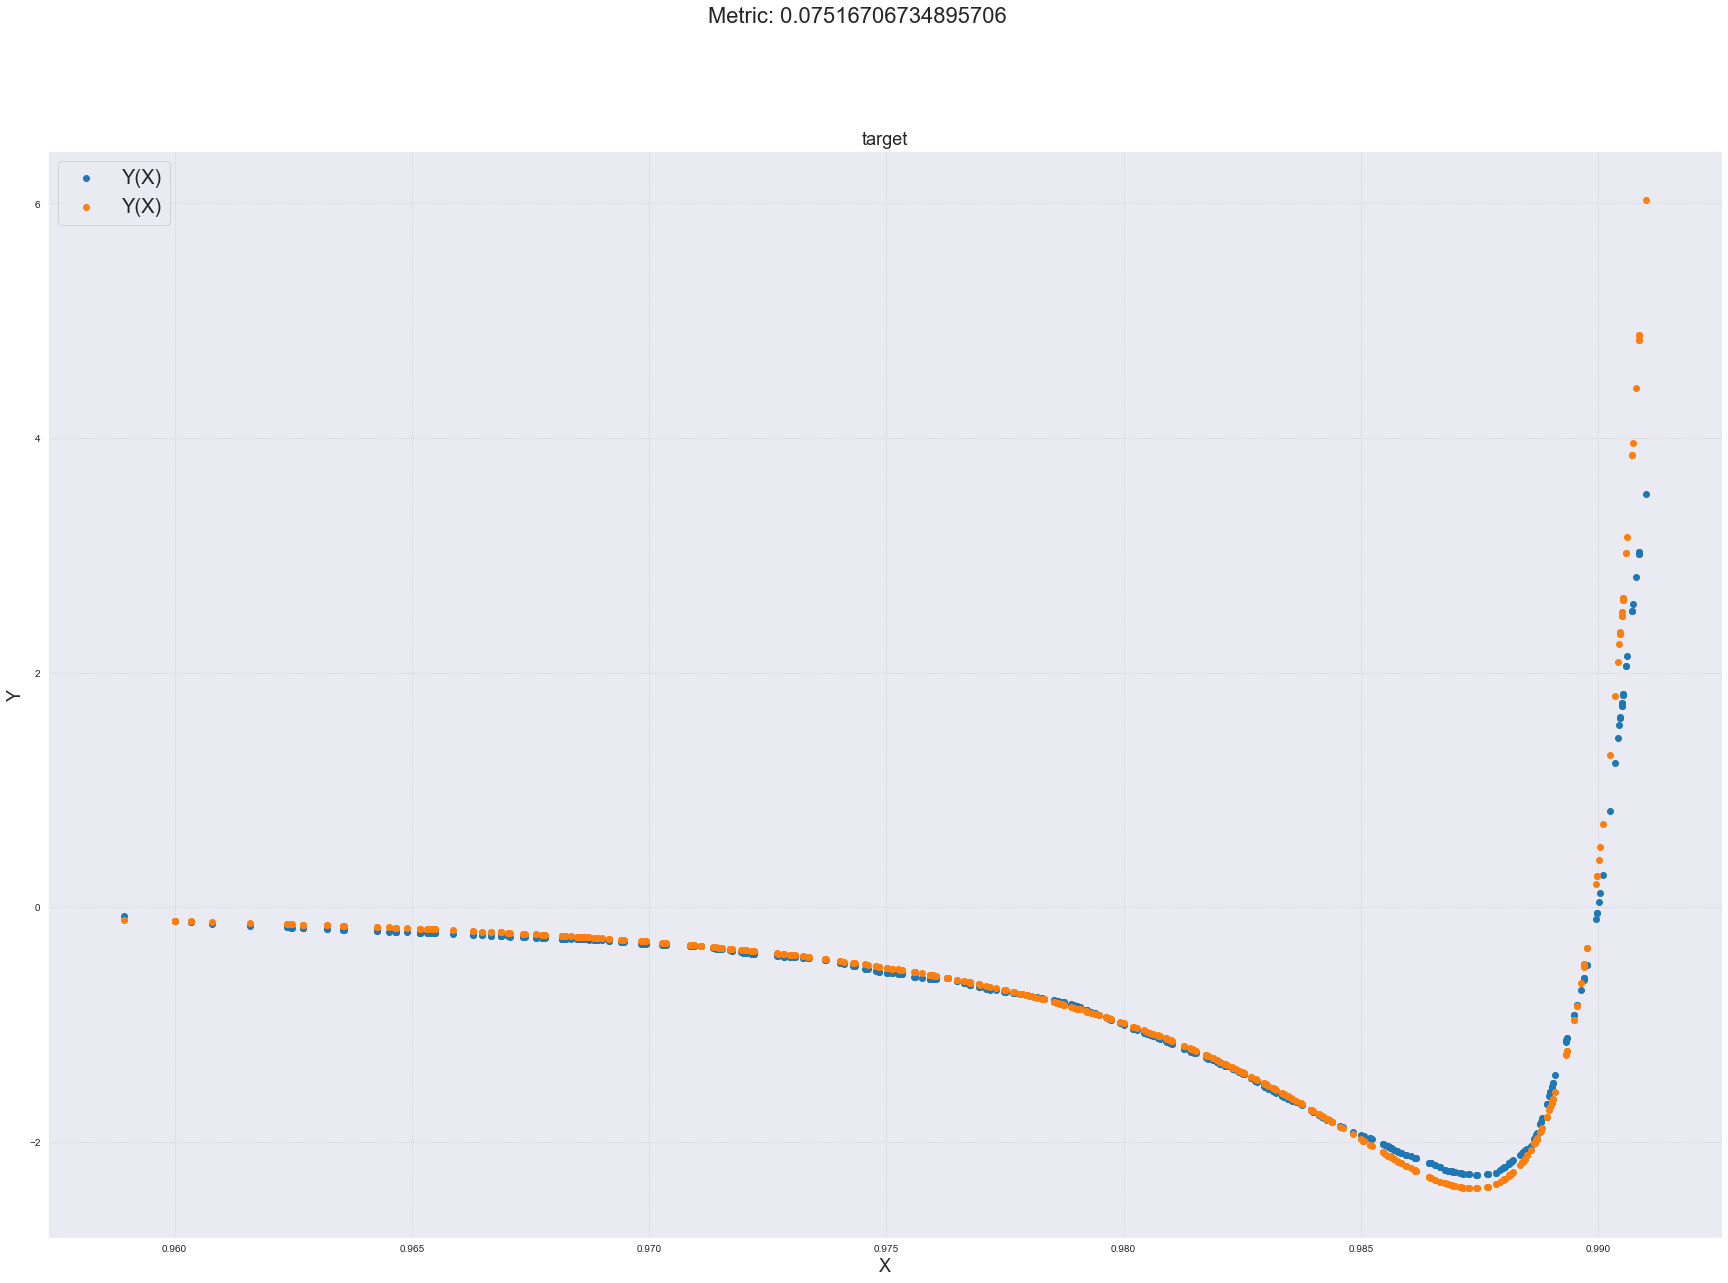

In [145]:
make_predictions_and_plot(model=model, data=train_data, same_axis=True)

In [146]:
a = torch.tensor(
    [[1., 2, 3], 
    [4., 5, 6]]
)

b = torch.tensor([[4., 5, 6], [1., 2, 3]])

crit = nn.MSELoss()

In [147]:
crit(a, b)

tensor(9.)